In [132]:
import torch
import numpy as np
from models import WorldModel
import matplotlib.pyplot as plt
import yaml
from utils import AttrDict

In [133]:
class PID:
    def __init__(self, kp, ki, kd, dt, integrator_min=-float('inf'), integrator_max=float('inf')):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_min = integrator_min
        self.integrator_max = integrator_max

    def update(self, error):
        # Update integral term with clamping to avoid windup
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, self.integrator_min, self.integrator_max)
        # Compute derivative term
        derivative = (error - self.prev_error) / self.dt
        # Compute PID output
        output = self.kp * error + self.ki * self.integrator + self.kd * derivative
        self.prev_error = error
        return output

In [ ]:
# Load the world model
with open("/home/eashan/workspace/DreamingFalconROS/config.yaml", 'r') as file:
    config_dict = yaml.safe_load(file)

config = AttrDict.from_dict(config_dict)
world_model = WorldModel(config, torch.device(config.device)).to(config.device)
checkpoint = torch.load("/home/eashan/workspace/DreamingFalconROS/models/run_x/model.pt")
world_model.load_state_dict(checkpoint["state_dict"])
world_model.eval()  # Set to evaluation mode

# Simulation parameters
dt = 0.05        # time step in seconds
T = 50.0         # total simulation time in seconds
num_steps = int(T / dt)

# Initialize the state vector
# Assuming: [x, y, z, vx, vy, vz, roll, pitch, yaw, roll_rate, pitch_rate, yaw_rate]
state = torch.zeros(12, dtype=torch.float32)
# You may initialize altitude, velocities, etc., as needed:
state[2] = 0.0  # Altitude
state[3] = 0.0  # Initial vx

# Initialize the PID controllers for each loop
# These gains are illustrative; tune them based on your system's dynamics.
pid_velocity = PID(kp=1.0, ki=0.0, kd=0.05, dt=dt)   # Outer loop: velocity
pid_attitude = PID(kp=1.0, ki=0.0, kd=0.05, dt=dt)   # Middle loop: attitude (pitch)
pid_rate     = PID(kp=1.0, ki=0.0, kd=0.05, dt=dt)   # Inner loop: pitch rate

# Logging for plotting
time_log = []
velocity_log = []
target_velocity_log = []
pitch_log = []
desired_pitch_log = []
pitch_rate_log = []
desired_pitch_rate_log = []

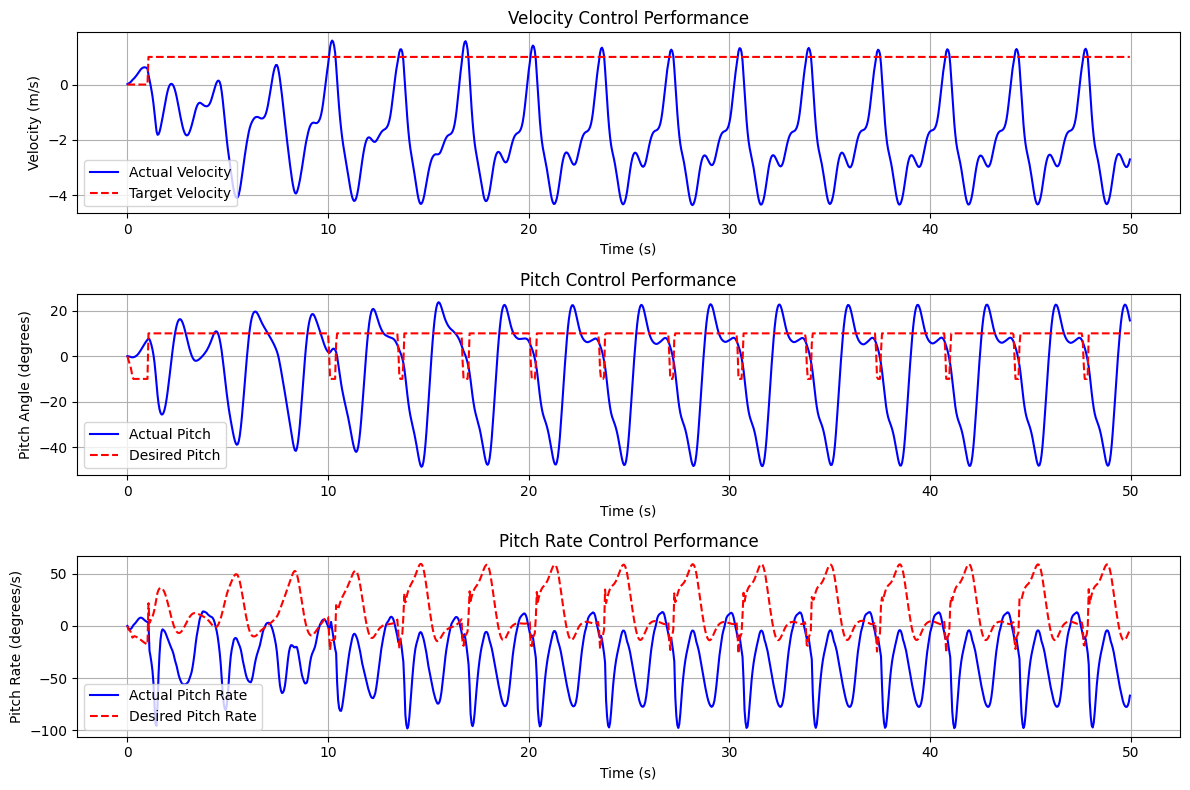

In [135]:
# Simulation loop
for step in range(num_steps):
    t = step * dt

    # Define target velocity (step input: 0 until t=1s, then 1 m/s)
    target_velocity = 1.0 if t > 1.0 else 0.0

    # Extract current velocity (vx is assumed at index 3)
    current_velocity = state[3].item()

    # ---- Outer Loop: Velocity Control ----
    # Compute error between target and current velocity and update PID
    error_velocity = target_velocity - current_velocity
    # PID output is interpreted as a desired pitch angle command
    desired_pitch = pid_velocity.update(error_velocity)
    # Limit the desired pitch angle to ±10° (converted to radians)
    max_pitch = np.radians(10)
    desired_pitch = np.clip(desired_pitch, -max_pitch, max_pitch)

    # ---- Middle Loop: Attitude Control (Pitch) ----
    # Assume actual pitch is at index 7 of the state vector
    actual_pitch = state[7].item()
    error_attitude = desired_pitch - actual_pitch
    # PID computes desired pitch rate from pitch error
    desired_pitch_rate = pid_attitude.update(error_attitude)

    # ---- Inner Loop: Rate Control (Pitch Rate) ----
    # Assume actual pitch rate is at index 10 of the state vector
    actual_pitch_rate = state[10].item()
    error_rate = desired_pitch_rate - actual_pitch_rate
    rate_command = pid_rate.update(error_rate)

    # ---- Actuator Mixing ----
    # For a quadcopter, assume a base throttle that maintains hover (e.g., 0.6 out of 1.0)
    base_throttle = 0.6
    # For pitch control: decrease front motors and increase rear motors
    actuator_commands = torch.tensor([
        base_throttle - rate_command,  # Motor 0 (front left)
        base_throttle - rate_command,  # Motor 1 (front right)
        base_throttle + rate_command,  # Motor 2 (rear left)
        base_throttle + rate_command   # Motor 3 (rear right)
    ], dtype=torch.float32)

    # ---- World Model Prediction ----
    # Compute the next state using the world model's predict() function
    with torch.no_grad():
        state = world_model.predict(torch.tensor([dt], dtype=torch.float32).unsqueeze(0), state.unsqueeze(0), actuator_commands.unsqueeze(0)).squeeze(0)

    # Log data for plotting
    time_log.append(t)
    velocity_log.append(state[3].item())  # Log actual vx
    target_velocity_log.append(target_velocity)
    pitch_log.append(actual_pitch)
    desired_pitch_log.append(desired_pitch)
    pitch_rate_log.append(actual_pitch_rate)
    desired_pitch_rate_log.append(desired_pitch_rate)

# After the simulation loop, add this plotting code
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Subplot 1: Velocity Tracking
plt.subplot(3, 1, 1)
plt.plot(time_log, velocity_log, 'b-', label='Actual Velocity')
plt.plot(time_log, target_velocity_log, 'r--', label='Target Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Control Performance')
plt.grid(True)
plt.legend()

# Subplot 2: Attitude (Pitch) Tracking
plt.subplot(3, 1, 2)
plt.plot(time_log, [np.degrees(p) for p in pitch_log], 'b-', label='Actual Pitch')
plt.plot(time_log, [np.degrees(p) for p in desired_pitch_log], 'r--', label='Desired Pitch')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (degrees)')
plt.title('Pitch Control Performance')
plt.grid(True)
plt.legend()

# Subplot 3: Rate (Pitch Rate) Tracking
plt.subplot(3, 1, 3)
plt.plot(time_log, [np.degrees(r) for r in pitch_rate_log], 'b-', label='Actual Pitch Rate')
plt.plot(time_log, [np.degrees(r) for r in desired_pitch_rate_log], 'r--', label='Desired Pitch Rate')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Rate (degrees/s)')
plt.title('Pitch Rate Control Performance')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
